# COMPUTACIÓN DE ALTAS PRESTACIONES
## Práctica #1 - Procesamiento de datos mediante Apache Spark

* Martha María Del Toro Carballo       100486134@alumnos.uc3m.es
* Brandon Solo                         100405959@alumnos.uc3m.es
* Manuel Santiago Férnandez Arias      manuefer@inf.uc3m.es

### Inicializando Spark

In [1]:
# !apt-get update
# !apt-get install openjdk-8-jdk-headless -qq > /dev/null
# !wget -q https://dlcdn.apache.org/spark/spark-3.1.3/spark-3.1.3-bin-hadoop3.2.tgz
# !tar xf spark-3.1.3-bin-hadoop3.2.tgz
# !pip install -q findspark

Reading package lists... Done
E: Could not open lock file /var/lib/apt/lists/lock - open (13: Permission denied)
E: Unable to lock directory /var/lib/apt/lists/
W: Problem unlinking the file /var/cache/apt/pkgcache.bin - RemoveCaches (13: Permission denied)
W: Problem unlinking the file /var/cache/apt/srcpkgcache.bin - RemoveCaches (13: Permission denied)
E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


In [2]:
import os
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-3.1.3-bin-hadoop3.2"

In [3]:
import findspark
findspark.init()

In [4]:
num_cores = 3

In [5]:
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf

conf = SparkConf().set('spark.ui.port', '4050')
sc = SparkContext(conf=conf)
spark = SparkSession.builder.master(f'local[{num_cores}]').getOrCreate() 

spark

22/11/11 00:11:26 WARN Utils: Your hostname, pop-os resolves to a loopback address: 127.0.1.1; using 192.168.1.35 instead (on interface enp3s0)
22/11/11 00:11:26 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/11/11 00:11:27 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [6]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

Your runtime has 33.0 gigabytes of available RAM



### Otras librerías a usar

In [2]:
from datetime import datetime
from time import time
import numpy as np
from csv import writer
import matplotlib.pyplot as plt
from operator import add
from pyspark.sql import functions as F
import os
import pandas as pd
from operator import add
import seaborn as sns

### Funciones

In [8]:
cant_datos = 0
result_count = 0
tiempo_ejecucion = 0
velocidad_ejecucion = 0

def calcularRendimiento(results, cant_datos):
    t_0 = time()
    result_count = results.count() # Acción
    t_1 = time()
    tiempo_ejecucion = np.round(t_1 - t_0, 3)
    velocidad_ejecucion = round(cant_datos / tiempo_ejecucion, 2)

    return result_count , tiempo_ejecucion , velocidad_ejecucion

def interpretar_rendimiento(tiempo_ejecucion,velocidad_ejecucion,cant_datos):
    print(f'Han transcurrido {tiempo_ejecucion} segundos de ejecución.')
    print(f'Cantidad de datos procesados: {cant_datos}')
    print(f'Velocidad de procesamiento: {velocidad_ejecucion} registros/s')
  
def mostrar_grafico(data1, data2, title, cant_datos, legend = ['sql', 'rdd', 'data_frame'], n_cores = 4):
    x = [i for i in range(1,n_cores + 1)] # n_cores

    plt.figure(1, [14, 5], 150)

    plt.subplot(121)
    plt.title(title)
    plt.ylabel("Tiempo de ejecución (seg.)")
    plt.xlabel("Número de cores")
    plt.grid(True)
    plt.xticks(x)

    for y in data1:
        plt.plot(x, y)

    plt.legend(legend)

    plt.subplot(122)
    plt.title("Cantidad de registros: " + str(cant_datos))
    plt.ylabel("Registros procesados por segundo")
    plt.xlabel("Número de cores")
    plt.grid(True)
    plt.xticks(x)

    for y in data2:
        plt.plot(x, y)

    plt.legend(legend)

    plt.show()

def mostrar_resultados_rdd(results,columns,nfilas = 10):
    df = pd.DataFrame(results.take(nfilas), columns = columns)
    return df.style

def mostar_resultados_sql_df(results,nfilas = 10):
    return results.limit(nfilas).toPandas()



# Obtención de los datos

In [9]:
# Datos generales
path = "tripdata_2017-01.csv"
df_data = spark.read.csv(path, header=True, inferSchema=True)

path = "taxi+_zone_lookup.csv"
#df_zones = spark.read.csv(path, header=True, inferSchema=True)
df_zones = spark.read.option("delimiter", ";").csv(path, header=True, inferSchema=True)

# Limpieza de Datos



## Análisis previo de los datos

A continuación se hace un breve análisis de los datos

In [10]:
df_data.select("total_amount").describe().show()

+-------+------------------+
|summary|      total_amount|
+-------+------------------+
|  count|            971010|
|   mean|16.078110822760525|
| stddev| 546.7901022658476|
|    min|            -120.3|
|    max|          538580.0|
+-------+------------------+



In [11]:
df_data.select("tip_amount").describe().show()

+-------+------------------+
|summary|        tip_amount|
+-------+------------------+
|  count|            971010|
|   mean| 1.679028269533815|
| stddev|2.5713641104199563|
|    min|             -6.06|
|    max|             366.0|
+-------+------------------+



In [12]:
df_data.select("trip_distance").describe().show()

+-------+------------------+
|summary|     trip_distance|
+-------+------------------+
|  count|            971010|
|   mean| 3.031284878631532|
| stddev|3.7858472332117032|
|    min|               0.0|
|    max|             151.7|
+-------+------------------+



In [13]:
df_data.select("passenger_count").describe().show()

+-------+------------------+
|summary|   passenger_count|
+-------+------------------+
|  count|            971010|
|   mean|1.6859888157691476|
| stddev|1.2917046837574013|
|    min|                 0|
|    max|                 9|
+-------+------------------+



Representación de la dispersión y valores atípicos de propinas mediante un boxplot

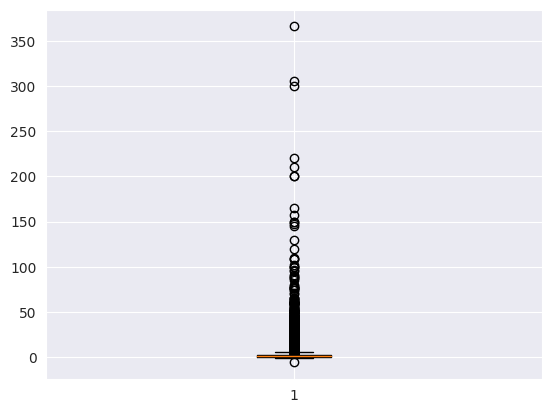

In [14]:
data = df_data.select("tip_amount").rdd.flatMap(lambda x: x).collect()

plt.boxplot(data)
plt.show()

## Limpieza de datos nulos

In [15]:
# -------- Limpieza en datos generales --------
rows1 = df_data.count()

# Eliminación de nulos
df_data_filtered = df_data.dropna()

rows2 = df_data_filtered.count()

print("Cantidad de filas eliminadas: " + str(rows1 - rows2))

Cantidad de filas eliminadas: 0


In [16]:
# -------- Limpieza en datos de zonas --------
rows1 = df_zones.count()

# Eliminación de nulos
df_zones_filtered = df_zones.dropna()

listaNulos = ["Unknown", "NA", "N/A"]

rdd_df_filtered = df_zones_filtered.rdd.filter(lambda x: x.Borough not in listaNulos)     \
                                       .filter(lambda x: x.Zone not in listaNulos)        \
                                       .filter(lambda x: x.service_zone not in listaNulos)

df_zones_filtered = spark.createDataFrame(rdd_df_filtered)
rows2 = df_zones_filtered.count()

print("Cantidad de filas eliminadas: " + str(rows1 - rows2))

Cantidad de filas eliminadas: 2


## Eliminación de valores sin sentido lógico

A partir del análisis previo de los datos se detectaron valores negativos o iguales a 0. Por tanto, se procede a eliminar las filas que contienen:
- Propinas negativas
- Distancia de viajes negativa o igual a 0
- Coste del viaje negativo o igual a 0
- Tiempos sin sentido (llegada antes o igual que salida)

In [17]:
rows1 = df_data_filtered.count()

# Filtrando propinas, importes negativos y tiempos
rdd_df_filtered = df_data_filtered.rdd.filter(lambda x: x.tip_amount >= 0) \
                                      .filter(lambda x: x.trip_distance > 0) \
                                      .filter(lambda x: x.total_amount >= 0) \
                                      .filter(lambda x: x.passenger_count > 0)

df_data_filtered = spark.createDataFrame(rdd_df_filtered)
rows2 = df_data_filtered.count()

print("Cantidad de filas eliminadas: " + str(rows1 - rows2))

Cantidad de filas eliminadas: 6709


## Filtrado de los valores atípicos

In [18]:
quantiles = df_data_filtered.approxQuantile("tip_amount", [0.25, 0.75], 0.0)
Q1 = quantiles[0]
Q3 = quantiles[1]
IQR = Q3 - Q1
upperRange = Q3 + 3*IQR
rdd_df_filtered = df_data_filtered.rdd.filter(lambda x: x.tip_amount < upperRange)

df_data_filtered = spark.createDataFrame(rdd_df_filtered)
rows2 = df_data_filtered.count()

print("Cantidad de filas eliminadas: " + str(rows1 - rows2))

Cantidad de filas eliminadas: 29837


Representación de la dispersión resultante del filtrado de valores atípicos teniendo en cuenta las propinas mediante un boxplot

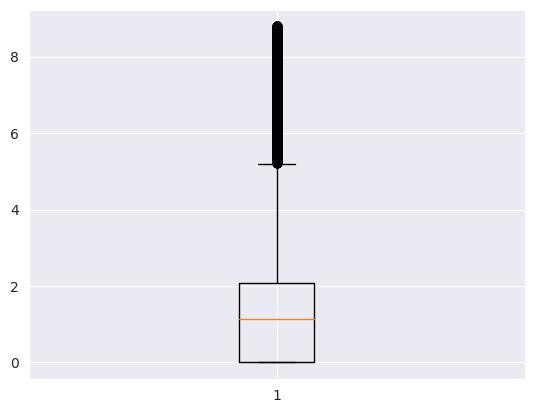

In [19]:
data = df_data_filtered.select("tip_amount").rdd.flatMap(lambda x: x).collect()

plt.boxplot(data)
plt.show()

## Conversión del formato de tiempo

In [20]:
from pyspark.sql.functions import to_timestamp

df_data_final = df_data_filtered.withColumn("tpep_pickup_datetime", to_timestamp("tpep_pickup_datetime"))
df_data_final = df_data_final.withColumn("tpep_dropoff_datetime", to_timestamp("tpep_dropoff_datetime"))

Ahora que tenemos las columnas de Pickup y Dropoff formateadas a *timestamp*, se filtran los datos buscando un orden lógico de fechas:

*   El tiempo de llegada es mayor que el de salida
*   Los tiempos son diferentes

In [21]:
df_data_final = df_data_final.rdd.filter(lambda x: (x.tpep_dropoff_datetime - x.tpep_pickup_datetime).seconds > 0)
df_data_final = spark.createDataFrame(df_data_final)

Traceback (most recent call last):
  File "/home/brandon/.conda/envs/CAP/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 186, in manager
  File "/home/brandon/.conda/envs/CAP/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 74, in worker
  File "/home/brandon/.conda/envs/CAP/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 643, in main
    if read_int(infile) == SpecialLengths.END_OF_STREAM:
  File "/home/brandon/.conda/envs/CAP/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 564, in read_int
    raise EOFError
EOFError


## Join con los datos de las zonas

In [22]:
# ------- JOIN PULocation con la tabla de zonas -------
df_data_j = df_data_final.join(df_zones_filtered, on=[df_data_final.PULocationID == df_zones_filtered.LocationID], how = 'inner')

# Eliminación de columna redundante 
df_data_j = df_data_j.drop("LocationID")

# Renombrado de las nuevas columnas  
df_data_j = df_data_j.withColumnRenamed("Borough","PUBorough")
df_data_j = df_data_j.withColumnRenamed("Zone","PUZone")
df_data_j = df_data_j.withColumnRenamed("service_zone","PUService_zone")

# ------- JOIN DOLocation con la tabla de zonas -------
df_data_j = df_data_j.join(df_zones_filtered, df_data_final.DOLocationID == df_zones_filtered.LocationID, how='inner')

# Eliminación de columna redundante 
df_data_j = df_data_j.drop("LocationID")

# Renombrado de las nuevas columnas  
df_data_j = df_data_j.withColumnRenamed("Borough","DOBorough")
df_data_j = df_data_j.withColumnRenamed("Zone","DOZone")
df_data_j = df_data_j.withColumnRenamed("service_zone","DOService_zone")

cant_datos = df_data_j.count()

# Enunciado de la práctica

Realice los estudios que considere necesarios sobre los datos que contiene los registros de la compañía YellowCab de Nueva York en término de viajes en taxi. Es obligatorio proporcionar al menos tres estudios. Ejemplos de estudios:

1. Velocidad media de los taxis en función de la hora.
2. Viajes en taxi más comunes
3. Registros financieros (propinas, personas, etc.)

Será necesario realizar al menos una ejecución basada en una consulta SQL (spark.sql(.....)), al menos una consulta mediante una concatenación de llamadas a métodos del DataFrame como: select, groupBy, y finalmente una haciendo uso de RDDs. Con el objetivo de estudiar el mejor método de trabajo, uno de los estudios realizados tiene que estar implementado de las tres formas.

Tendrá que preparar un informe, indicando los siguientes aspectos:
*   Tiempo de ejecución.
*   Cantidad de datos procesados en término de número de viajes.
*   Velocidad de procesamiento.

## Consulta #1: Velocidad media de los taxis en función de la hora

##### **RDD**


Para obtener el resultado deseado se creó una función velocidad_media que se aplicará al conjunto de datos con map (rdd).

In [23]:
def velocidad_media(x):
    distancia = x.trip_distance
    t_destino = x.tpep_dropoff_datetime
    t_origen = x.tpep_pickup_datetime

    tiempo = (t_destino - t_origen).seconds / 3600

    return distancia / tiempo

In [24]:
results1 = df_data_j.rdd.map(velocidad_media)

Rendimiento:

In [25]:
result_count1 , tiempo_ejecucion1 , velocidad_ejecucion1 =  calcularRendimiento(results1, cant_datos)
interpretar_rendimiento(tiempo_ejecucion1, velocidad_ejecucion1, cant_datos)

Han transcurrido 13.127 segundos de ejecución.
Cantidad de datos procesados: 923696
Velocidad de procesamiento: 70366.12 registros/s


In [26]:
mostrar_resultados_rdd(results1,['Velocidad media en millas por hora'])

,Velocidad media en millas por hora
0,613.469388
1,34.285714
2,5.806452
3,38.571429
4,31.764706
5,8.344371
6,11.775701
7,18.000000
8,20.964706
9,24.768000


## Consulta #2: Viajes en taxi más comunes

##### **SQL**


Esta consulta obtiene los viajes en taxi más comunes en función del destino y del origen de la zona de Nueva York. Esta consulta se realizó mediante SQL y se ordenó la salida descendentemente para hacer un top 10 de los viajes más comunes.

In [27]:
df_data_j.createOrReplaceTempView('data')
results2 = spark.sql("SELECT COUNT(*) AS CANTIDAD_VIAJES, PUZone, DOZone \
                     FROM data \
                     GROUP BY PUZone, DOZone \
                     ORDER BY CANTIDAD_VIAJES DESC")

Rendimiento:

In [28]:
result_count2, tiempo_ejecucion2, velocidad_ejecucion2 =  calcularRendimiento(results2, cant_datos)
interpretar_rendimiento(tiempo_ejecucion2 , velocidad_ejecucion2, cant_datos)

Han transcurrido 10.18 segundos de ejecución.
Cantidad de datos procesados: 923696
Velocidad de procesamiento: 90736.35 registros/s


In [29]:
mostar_resultados_sql_df(results2)

,CANTIDAD_VIAJES,PUZone,DOZone
0,3428,Upper East Side South,Upper East Side North
1,3123,Upper East Side North,Upper East Side North
2,3005,Upper East Side North,Upper East Side South
3,2938,Times Sq/Theatre District,West Chelsea/Hudson Yards
4,2804,East Village,East Village
5,2689,Upper East Side South,Upper East Side South
6,2592,Upper West Side South,Lincoln Square East
7,2533,Upper West Side South,Upper West Side North
8,2465,Lincoln Square East,Upper West Side South
9,2200,Times Sq/Theatre District,Penn Station/Madison Sq West


##### **RDD**


Esta consulta tiene el mismo propósito que la anterior, pero se realizó mediante RDD, empleando map y reduceByKey

In [30]:
results3 = df_data_j.rdd.map(lambda x: (str(x.PUBorough + " [" + x.PUZone + "]" + " -> " + x.PUBorough + " [" + x.DOZone + "]"), 1)) \
                       .reduceByKey(add) \
                       .sortBy(lambda x: x[1], False)

Rendimiento:

In [31]:
result_count3, tiempo_ejecucion3, velocidad_ejecucion3 =  calcularRendimiento(results3, cant_datos)
interpretar_rendimiento(tiempo_ejecucion3 , velocidad_ejecucion3, cant_datos)

Han transcurrido 2.127 segundos de ejecución.
Cantidad de datos procesados: 923696
Velocidad de procesamiento: 434271.74 registros/s


In [32]:
mostrar_resultados_rdd(results3,['Trayecto', 'Cantidad de Viajes'])

,Trayecto,Cantidad de Viajes
0,Manhattan [Upper East Side South] -> Manhattan [Upper East Side North],3428
1,Manhattan [Upper East Side North] -> Manhattan [Upper East Side North],3123
2,Manhattan [Upper East Side North] -> Manhattan [Upper East Side South],3005
3,Manhattan [Times Sq/Theatre District] -> Manhattan [West Chelsea/Hudson Yards],2938
4,Manhattan [East Village] -> Manhattan [East Village],2804
5,Manhattan [Upper East Side South] -> Manhattan [Upper East Side South],2689
6,Manhattan [Upper West Side South] -> Manhattan [Lincoln Square East],2592
7,Manhattan [Upper West Side South] -> Manhattan [Upper West Side North],2533
8,Manhattan [Lincoln Square East] -> Manhattan [Upper West Side South],2465
9,Manhattan [Times Sq/Theatre District] -> Manhattan [Penn Station/Madison Sq West],2200


## Consulta #3: Propina media en funcion del número de pasajeros

##### **SQL**


Para obtener el resultado deseado mediante SQL agrupamos el resultado por el número de pasajeros y para cada uno se realiza la media.

In [33]:
df_data_j.createOrReplaceTempView('data')
results4 = spark.sql("SELECT passenger_count, AVG(tip_amount) \
                     FROM data \
                     GROUP BY passenger_count \
                     ORDER BY passenger_count ASC")

Rendimiento:

In [34]:
result_count4 , tiempo_ejecucion4 , velocidad_ejecucion4 =  calcularRendimiento(results4, cant_datos)
interpretar_rendimiento(tiempo_ejecucion4 , velocidad_ejecucion4, cant_datos)

Han transcurrido 10.398 segundos de ejecución.
Cantidad de datos procesados: 923696
Velocidad de procesamiento: 88834.01 registros/s


In [35]:
mostar_resultados_sql_df(results4)

,passenger_count,avg(tip_amount)
0,1,1.425553
1,2,1.430132
2,3,1.349700
3,4,1.205851
4,5,1.425809
5,6,1.400791


##### **RDD**


Para obtener el resultado deseado mediante RDD Se usarán las funciones de transformación map y reduceByKey mediante cual se asignará a cada clave (Passenger_count) el valor de la propina media que le corresponde a cada una.

In [36]:
results5 = df_data_j.rdd.map(lambda x: (x.passenger_count, (x.tip_amount, 1))) \
                       .reduceByKey(lambda x, y: (x[0]+y[0], x[1]+y[1])) \
                       .map(lambda x: (x[0], x[1][0] / x[1][1]))

Rendimiento:

In [37]:
result_count5, tiempo_ejecucion5, velocidad_ejecucion5 =  calcularRendimiento(results5, cant_datos)
interpretar_rendimiento(tiempo_ejecucion5, velocidad_ejecucion5, cant_datos)

Han transcurrido 3.77 segundos de ejecución.
Cantidad de datos procesados: 923696
Velocidad de procesamiento: 245012.2 registros/s


In [38]:
mostrar_resultados_rdd(results5,['Número de pasajeros', 'Propina media'])

,Número de pasajeros,Propina media
0,1,1.425553
1,2,1.430132
2,3,1.349700
3,4,1.205851
4,5,1.425809
5,6,1.400791


##### **DataFrame**


El resultado se obtiene aplicando una agrupación por el campo "passenger_count", donde con el resultado obtenido se realiza una agregación por "tip_amount" (propina) y se ordena ascendentemente por el número de pasajeros.

In [39]:
results6 = df_data_j.groupBy("passenger_count") \
                   .agg(F.mean('tip_amount'), F.min('tip_amount'), F.max('tip_amount')) \
                   .orderBy('passenger_count')

Rendimiento:

In [40]:
result_count6, tiempo_ejecucion6, velocidad_ejecucion6 =  calcularRendimiento(results6, cant_datos)
interpretar_rendimiento(tiempo_ejecucion6, velocidad_ejecucion6, cant_datos)

Han transcurrido 9.841 segundos de ejecución.
Cantidad de datos procesados: 923696
Velocidad de procesamiento: 93862.01 registros/s


In [41]:
mostar_resultados_sql_df(results6)

,passenger_count,avg(tip_amount),min(tip_amount),max(tip_amount)
0,1,1.425553,0.0,8.79
1,2,1.430132,0.0,8.79
2,3,1.349700,0.0,8.79
3,4,1.205851,0.0,8.77
4,5,1.425809,0.0,8.79
5,6,1.400791,0.0,8.79


## Guardando los resultados

In [42]:
final_results_df = pd.DataFrame([
  [result_count1, tiempo_ejecucion1, velocidad_ejecucion1],
  [result_count2, tiempo_ejecucion2, velocidad_ejecucion2],
  [result_count3, tiempo_ejecucion3, velocidad_ejecucion3],
  [result_count4, tiempo_ejecucion4, velocidad_ejecucion4],
  [result_count5, tiempo_ejecucion5, velocidad_ejecucion5],
  [result_count6, tiempo_ejecucion6, velocidad_ejecucion6],
], index=["c1_rdd", "c2_sql", "c2_rdd", "c3_sql", "c3_rdd", "c3_df"], columns = ["count", "tiempo", "velocidad"])
final_results_df.index.name = "id"
final_results_df

,count,tiempo,velocidad
id,,,
c1_rdd,923696,13.127,70366.12
c2_sql,15687,10.180,90736.35
c2_rdd,15687,2.127,434271.74
c3_sql,6,10.398,88834.01
c3_rdd,6,3.770,245012.20
c3_df,6,9.841,93862.01


In [43]:
final_results_df.to_csv(f"final_results/final_result_{num_cores}.csv", sep=";")

## Gráficas

### Consulta 1

In [24]:
partial_final_result_df_list = []

for i in range(1, 7):
    partial_final_result_df = pd.read_csv(f"final_results/final_result_{i}.csv", sep=";")
    partial_final_result_df["num_cores"] = i
    partial_final_result_df_list.append(partial_final_result_df)


final_results_df = pd.concat(partial_final_result_df_list).reset_index(drop=True)
final_results_df

,id,count,tiempo,velocidad,num_cores
0,c1_rdd,923696,17.636,52375.60,1
1,c2_sql,15687,17.021,54268.02,1
2,c2_rdd,15687,2.254,409803.02,1
3,c3_sql,6,14.471,63830.83,1
4,c3_rdd,6,3.799,243141.88,1
5,c3_df,6,14.547,63497.35,1
6,c1_rdd,923696,12.781,72271.03,2
7,c2_sql,15687,11.109,83148.44,2
8,c2_rdd,15687,2.186,422550.78,2
9,c3_sql,6,10.263,90002.53,2


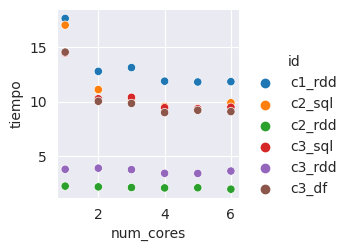

In [25]:
sns.pairplot(final_results_df, x_vars=["num_cores"], y_vars=["tiempo"], hue="id")

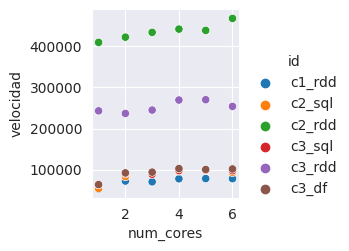

In [26]:
sns.pairplot(final_results_df, x_vars=["num_cores"], y_vars=["velocidad"], hue="id")